#Churn Analysis of  Bank Customers

##Introduction

Customer churn analysis of bank customers provides an insight into the causes of customers leaving the bank, and provide ways to reduce churn and retain customers. 

In this workbook, we analyze banking data, and build ML models to understand the causes of churn; the models can also predict the probability of customer retention/churn.

The analysis is carried out in two steps:
where first we perform **exploratory data analysis (EDA)**, followed by classification
task using various **Machine Learning** classifiers. The results of the second step and conclusions are provided at the end.

**Connect to gdrive**

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


**Import Libs**

In [2]:
from scipy.stats import mode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

**Load Dataset**

In [3]:
data  = pd.read_csv('MyDrive/MLData/Churn_Modelling.csv') 
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


Dataset contains 13 columns, with 3 non-numeric (object) data. 

##Data Exploration

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
data.describe(percentiles=[]).T

,count,mean,std,min,50%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,5.000500e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,1.569074e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,6.520000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,3.700000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,5.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,9.719854e+04,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,1.001939e+05,199992.48


Data shows that an average bank customer is about 39 years old, has balance of 76,000 and stays 5 years with the bank (tenure). Based on this and other data provided, we can infer which customer is likely to leave.



**Drop Row number, id, and surname** since they are not relavant.

In [6]:
data = data.drop(columns=['RowNumber','CustomerId','Surname'])

Data columns (attributes) is divided into categorical and continuous, we look at each 
separately.  

In [7]:
#Classify variables as categorical or continous
var_cat = ['Geography','Gender','Tenure','NumOfProducts',
           'HasCrCard','IsActiveMember']
var_con = ['Age','Balance','EstimatedSalary','CreditScore']
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Distributions of the four continous variables**

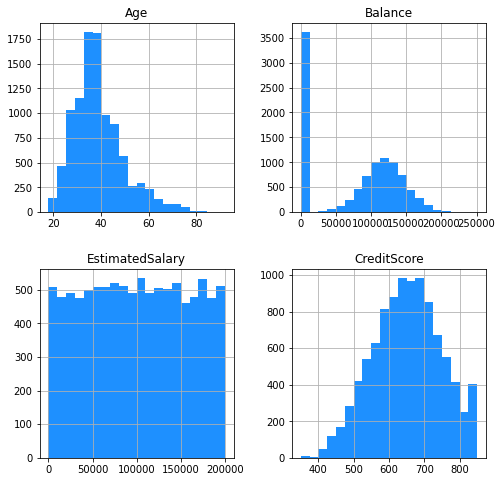

In [24]:
def plot_vars(var_list, dt):
  num_vars = len(var_list)
  nrows    = ceil(num_vars/2) 
  ncols    = 2 
  tmp_     = dt[var_list].hist(
      figsize=(8,nrows*4), bins=20,
      linewidth=1.5, layout=(nrows,ncols),
      color='dodgerblue'
      )

plot_vars(var_con,data)

The distributions show expected behavior:
*   age - 18-92, skewed towards the higher end
*   normal distributions of balance, credit score, with some zero balance customers
*   salary evenly distributed among all customers.

Therefore, we can use all four variables without much change, except scaling/normalization.

**Distributions of the six continous variables**

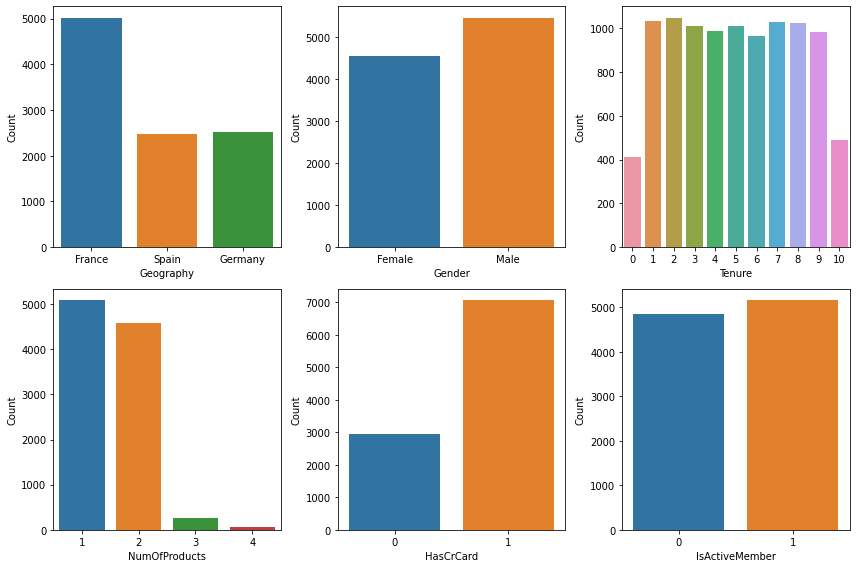

In [9]:
fig,ax   = plt.subplots(2,3,figsize=(12,8))
data_cat = data[var_cat]
for index,column in enumerate(data_cat.columns):
  plt.subplot(2,3,index+1)
  tmp_ = sns.countplot(x=column, data=data)
  plt.ylabel('Count')

plt.tight_layout()

Categorical data is gives interesting information: 
* Majority customers are French, while German, Spanish customers are about equal. 
* Evenly divided in gender groups, and tenure over 10 years,
* Most customers prefer to have about two products from the bank, and a credit card. 

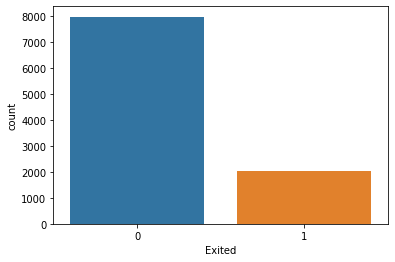

In [10]:
  tmp_ = sns.countplot(x=data['Exited'], data=data)

**Bank has 80% retention rate**, while 20% customers left the bank, in the ten year duration of the data.

----

**Correlation of Variables**

1. Correlation between churn and other variables
2. Correlation between predictor variables

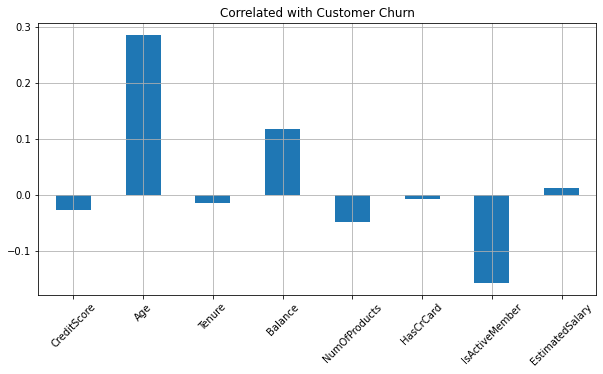

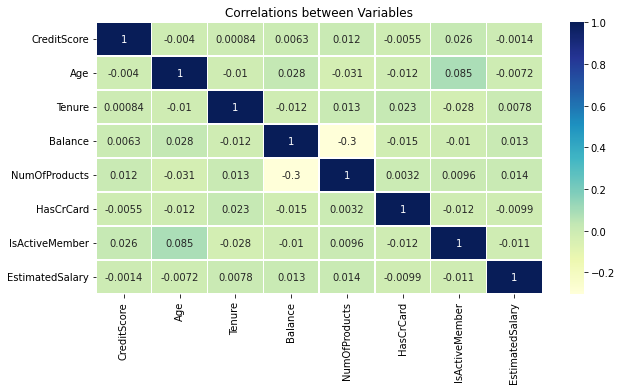

In [11]:
##Correlation
data2 = data.drop(columns='Exited')
tmp_  = data2.corrwith(data['Exited']).plot.bar(
    figsize=(10,5),title="Correlated with Customer Churn",
    rot=45,grid=True)

corr = data2.corr()
plt.figure(figsize=(10,5))
ax_ = sns.heatmap(corr,annot=True,linewidth=0.5,cmap="YlGnBu")
tmp_= ax_.set_title('Correlations between Variables')

* We see that all variables show some correlation with churn, and are therefore useful in modeling. Specifically, Age and active memeber is correlated well. 
* Among the predictor variable the Balance and NumProducts are have opposite coorelation. So, high balance customer have fewer products.
* Since Geography is non-numeric and categorical variable, its correlation cannot be calculated. Instead, we look at chi2 test to establish its significance for predicting churn.

**Chi2 Test**

In [12]:
chi2_arr, p_arr = [],[]
#crosstab = pd.crosstab(data['Geography'],data['Exited'],margins=True)
for column in var_cat: 
  crosstab = pd.crosstab(data[column],data['Exited'])
  chi2,p,dof,exp = chi2_contingency(crosstab)
  chi2_arr.append(chi2)
  p_arr.append(p)

data_chi2 = pd.DataFrame({'Variable':var_cat,'Chi2':chi2_arr,
                          'p-value':p_arr})
data_chi2.sort_values(by='Chi2',ascending=False) 

,Variable,Chi2,p-value
3,NumOfProducts,1503.629362,0.000000e+00
0,Geography,301.255337,3.830318e-66
5,IsActiveMember,242.985342,8.785858e-55
1,Gender,112.918571,2.248210e-26
2,Tenure,13.900373,1.775846e-01
4,HasCrCard,0.471338,4.923724e-01


Geography does predict customer churn, since it has high chi2 calculated from the contigency table.

##Pre-processing Data

**One-hot Variables: Geography, Gender**

In [13]:
data_fit = data.drop(columns=['Geography','Gender'])
dd1=pd.get_dummies(data['Geography'])
dd2=pd.get_dummies(data['Gender'],drop_first=True)
data_fit = pd.concat([data_fit.iloc[:,:-1],\
                      dd1,dd2,
                      data_fit.iloc[:,-1]],axis=1)
print(data_fit.columns.sort_values())

Index(['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Exited', 'France',
       'Germany', 'HasCrCard', 'IsActiveMember', 'Male', 'NumOfProducts',
       'Spain', 'Tenure'],
      dtype='object')


**Train/Test Split And Data Scaling**

In [14]:
#------------------------------------#
train_data,test_data = \
train_test_split(data_fit,test_size=0.4,random_state=15)
print ("Train data",train_data.shape)
print ("Test  data",test_data.shape )

#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scl_columns = ['Age','Balance','CreditScore','EstimatedSalary']
train_data[scl_columns] = sc.fit_transform(train_data [scl_columns])
test_data [scl_columns] = sc.transform    (test_data  [scl_columns])

#-----------------------------------#
##Imbalanced sample
from imblearn.over_sampling import SMOTE
over = SMOTE(sampling_strategy='auto',random_state=15)
x_train,y_train = train_data.iloc[:,:-1], train_data.iloc[:,-1]
x_test ,y_test  = test_data .iloc[:,:-1], test_data .iloc[:,-1]
x_train_smt, y_train_smt = over.fit_resample(x_train,y_train)

print ("Train: x",x_train.shape,"y",y_train.shape)
print ("Test : x",x_test .shape,"y",y_test .shape)
print ("SMOTE")
print("Train: x",x_train_smt.shape,\
             "y",y_train_smt.shape)
print("Test : x",x_train_smt.shape,\
              "y",y_train_smt.shape)




Train data (6000, 13)
Test  data (4000, 13)
Train: x (6000, 12) y (6000,)
Test : x (4000, 12) y (4000,)
SMOTE
Train: x (9552, 12) y (9552,)
Test : x (9552, 12) y (9552,)



##Machine Learning Models

**Baseline Performance and Models with Cross-Validation**

1. The following classifiers are test:
  * Logistic Regression
  * Naive Bayes
  * SVC
  * GB Decision Trees
  * Random Forest
  * KNN
  * MLP Neural Net

2. Accuracy metric is used for calculating score.

In [15]:
import sys
sys.path.append('MyDrive/modules')
from customer_churn_util import * 

#Collection of Models
models = {
    "Logistic Regression": LogisticRegression(random_state=10),
    "Gaussian NB":GaussianNB(),
    "SVC":SVC(),
    "Random Forest":RandomForestClassifier(random_state=10),
    "Gradient Boosted":GradientBoostingClassifier(random_state=10),
    "KNN":KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    "Neural Net":MLPClassifier(hidden_layer_sizes=(50,25,25,1)),
}

#Train each model, and cross validate (k-fold)
for model in models:
  m_  = models[model]
  sc1 = cross_val_score(m_, x_train, y_train, cv = 5,
                       n_jobs = -1,
                       scoring= cv_scoring)
  sc2 = cross_val_score(m_, x_train_smt, y_train_smt, cv = 5,
                       n_jobs = -1,
                       scoring= cv_scoring)


  print("--"*10)
  print("{0:20s} - Avg: {1:5.2f} (Unbalanced),  {2:5.2f} (SMOTE) ".format(\
        model, np.mean(sc1), np.mean(sc2)))
  


--------------------
Logistic Regression  - Avg:  0.81 (Unbalanced),   0.76 (SMOTE) 
--------------------
Gaussian NB          - Avg:  0.82 (Unbalanced),   0.76 (SMOTE) 
--------------------
SVC                  - Avg:  0.81 (Unbalanced),   0.80 (SMOTE) 
--------------------
Random Forest        - Avg:  0.86 (Unbalanced),   0.89 (SMOTE) 
--------------------
Gradient Boosted     - Avg:  0.86 (Unbalanced),   0.85 (SMOTE) 
--------------------
KNN                  - Avg:  0.82 (Unbalanced),   0.85 (SMOTE) 
--------------------
Neural Net           - Avg:  0.82 (Unbalanced),   0.57 (SMOTE) 


Overall, we see good performance, and Random Forest classifier gives the best accuracy.
Next, tune RandomForest to give the best performance and examine different metrics.

---


**Tuning Random Forest**

In [16]:
dt_score  = (x_train,y_train,x_test,y_test)
class_rf1 = RandomForestClassifier(random_state=0)
scores1, scores1_tr = get_scores (class_rf1,*dt_score)

class_rf2 = RandomForestClassifier(random_state=0,n_estimators=150,
                                   max_features=12,
                                   max_depth=10, min_samples_leaf=5,
                                   class_weight="balanced")
scores2, scores2_tr = get_scores (class_rf2,*dt_score)


dt_score  = (x_train_smt,y_train_smt,x_test,y_test)
class_rf3 = RandomForestClassifier(random_state=0,n_estimators=120,
                                   max_features=12,
                                   max_depth=10, min_samples_leaf=1,
                                   class_weight="balanced")

scores3, scores3_tr = get_scores (class_rf3,*dt_score)
#-------------------------------------------------------------------------------#
all_scores = pd.DataFrame(index=['Accuracy','TPR (Recall)',
                                 'TNR','AUC'])

all_scores["Train"]             = scores1_tr[0], scores1_tr[1], scores1_tr[6],scores1_tr[2]
all_scores["Default Pars"]      = scores1[0], scores1[1], scores1[6],scores1[2]
all_scores["Tuned Pars"]        = scores2[0], scores2[1], scores2[6],scores2[2]
all_scores["Tuned Pars+SMOTE"]  = scores3[0], scores3[1], scores3[6],scores3[2]

print("RandomForest Scores Table")
all_scores.T

RandomForest Scores Table


,Accuracy,TPR (Recall),TNR,AUC
Train,1.000,1.000000,1.000000,1.000000
Default Pars,0.858,0.452645,0.961406,0.707025
Tuned Pars,0.843,0.672817,0.886414,0.779615
Tuned Pars+SMOTE,0.813,0.626076,0.860684,0.743380


**Metrics, Class Balancing**

The classifiers do a good job identifying the negative cases, ie when a customer stays with the bank. Since this is the majority class (80%), training is easier. But we are really interested in the opposite, accurately identifying when customer will leave (positive case). 

1. The following *metrics* are used: **Accuracy, Recall** (true positive rate), **Specificty** (true negative rate), and **auc** (relative distribution of positive and negative rates at various classifying thresholds).
2. The class imbalance between postive and negative cases is addressed by RandomForest function with class_weight option, and by independently scaling data to equalize class population using SMOTE function. Testing both methods, we find recall and specificty improve with balanced classes, and the RandomForest in-built function works best. **Customer churn (TNR)is identified with 67% accuracy.**

**Feature Importances**

In [17]:
#Feature Importances
f_importance = class_rf2.feature_importances_
f_names      = class_rf2.feature_names_in_
f_dict  = { i:j for i,j in zip(f_names,f_importance)}
f_table = pd.DataFrame(f_dict,index=["Importance"])
f_table = f_table.T.sort_values(by='Importance',ascending=True)

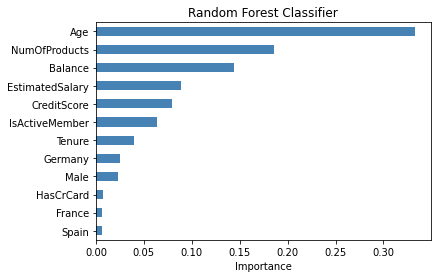

In [19]:
ax  = f_table.plot.barh(color='steelblue',legend=False)
txt = ax.set_xlabel('Importance')
txt = ax.set_title("Random Forest Classifier")

The most important features to determine if the customer will leave bank are age, number of products purchased, and balance.

**Conclusions**

Finally, we conclude the following from the analysis. 
* age, number of purchased products, and balance primarily contribute to customers leaving the bank. 
* the ML model can identify using customer data  customer rentention at 88%, and customer churn at 67% accuracy.